## Price Elasticity of Demand

### Problem_Statement /Business Problem

Our client, ABC Electronics is a company that produces and sells a variety of electronics goods, 
including speakers, laptops, and televisions. The company is facing a major challenge in managing 
their inventory. Despite their efforts to reduce costs and increase sales, they have noticed a decline
in sales for a particular category of products**. They believe that the decline in sales is due to a 
change in consumer behaviour, specifically in the way that consumers are responding to changes in price. 
In order to address this issue, ABC Electronics has asked us to perform a data science project on the 
Price Elasticity of Demand for their products.This project will be developed with the stakeholder's 
needs in mind and potentially deliver significant value to sales, marketing, and regulatory managers,
by providing data-driven insights into consumer behaviour and product demand.


### Requirements

In [367]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from scipy.stats import mode 
import re

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.metrics import euclidean_distances

from sklearn.tree import DecisionTreeRegressor,plot_tree

import statsmodels.api as sm

### Data_gathering

In [368]:
df=pd.read_csv('data.csv')    ## 
# df.head()                   

df.shape

(14592, 31)

In [375]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14592 entries, 0 to 14591
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   14592 non-null  object 
 1   prices.amountMax     14592 non-null  float64
 2   prices.amountMin     14592 non-null  float64
 3   prices.availability  12667 non-null  object 
 4   prices.condition     13189 non-null  object 
 5   prices.currency      14592 non-null  object 
 6   prices.dateSeen      14592 non-null  object 
 7   prices.isSale        14592 non-null  bool   
 8   prices.merchant      13820 non-null  object 
 9   prices.shipping      8793 non-null   object 
 10  prices.sourceURLs    14592 non-null  object 
 11  asins                14592 non-null  object 
 12  brand                14592 non-null  object 
 13  categories           14592 non-null  object 
 14  dateAdded            14592 non-null  object 
 15  dateUpdated          14592 non-null 

In [373]:
null_frame=pd.DataFrame(((df.isna().sum())/df.shape[0])*100,columns=['null_val'])  # calculation null value percentage
null_frame['data_type'] = df.dtypes
null_frame.T

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,name,primaryCategories,sourceURLs,upc,weight,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30
null_val,0.0,0.0,0.0,13.19216,9.614857,0.0,0.0,0.0,5.29057,39.740954,...,0.0,0.0,0.0,0.0,0.0,99.73273,99.876645,99.958882,99.917763,99.958882
data_type,object,float64,float64,object,object,object,object,bool,object,object,...,object,object,object,object,object,object,object,float64,object,object


In [370]:
df.columns
df.describe()

,prices.amountMax,prices.amountMin,Unnamed: 28
count,14592.000000,14592.000000,6.000000e+00
mean,509.578897,487.323215,8.850000e+11
std,1008.512738,967.083200,0.000000e+00
min,1.000000,1.000000,8.850000e+11
25%,79.990000,79.950000,8.850000e+11
50%,195.000000,188.035000,8.850000e+11
75%,499.990000,499.000000,8.850000e+11
max,26871.000000,26871.000000,8.850000e+11


## Data_cleaning

In [371]:
# f1
df['id'].isna().sum()
df['id'].nunique()

1245

In [372]:
df['prices.amountMax'].value_counts() # no null values
df['prices.amountMin'].value_counts() # no null values


99.99     218
149.99    190
199.99    187
59.99     172
79.99     164
         ... 
99.97       1
59.90       1
38.14       1
41.56       1
77.98       1
Name: prices.amountMin, Length: 4907, dtype: int64

In [376]:
# f-3
df['prices.availability']=np.where(df['prices.availability'].str.contains('Yes|TRUE|In Stock|yes|available'),'yes',
                          np.where(df['prices.availability'].str.contains('No|sold|FALSE|Retired|Discontinued'),'no',
                          np.where(df['prices.availability'].str.contains('Special Order|More on the Way|More Coming Soon'),
                                      'other','other')))
df['prices.availability'].value_counts()

yes      13967
other      539
no          86
Name: prices.availability, dtype: int64

In [377]:
# f-4
df['prices.condition']=np.where(df['prices.condition'].str.contains('New|new'),'new',
                       np.where(df['prices.condition'].str.contains('Refurbished|refurbished'),'refurbished','used'))
                          
df['prices.condition'].value_counts()

df['prices.condition'].unique()

array(['new', 'refurbished', 'used'], dtype=object)

### 5-df['prices.currency']

In [283]:
df['prices.currency'].value_counts()
# df['prices.currency'].isna().sum() no null values


USD    14496
CAD       53
EUR       33
SGD        8
GBP        2
Name: prices.currency, dtype: int64

### 6- df['prices.dateSeen']

Here we don't have impression count or quantity sold but our end goal is to check 
impact of price in quantity. so we need create this feature. dateseen is number of
times product has been seen in that day/week/month etc. Hence lets assume every seen is 1 quantity sold.
Steps - Split the dateseen and count the length of dates that serves as impression
Also, convert date seen into date column so we can utilize its date component

In [378]:
df['prices.dateSeen']      ##

0        2017-03-30T06:00:00Z,2017-03-10T22:00:00Z,2017...
1                                     2017-12-14T06:00:00Z
2                                     2017-09-08T05:00:00Z
3                                     2017-10-10T05:00:00Z
4                                     2017-08-28T07:00:00Z
                               ...                        
14587                                 2015-09-05T00:00:00Z
14588    2017-10-10T19:00:00Z,2017-09-06T17:00:00Z,2017...
14589                                 2018-03-05T11:00:00Z
14590                                 2016-03-22T00:00:00Z
14591                                 2015-12-05T00:00:00Z
Name: prices.dateSeen, Length: 14592, dtype: object

In [379]:
# we are adding a new feature as df['impression_count'] to see hoe many times it occure in a day
df['quantity_sold']=df['prices.dateSeen'].apply(lambda x : len(x.split(',')))

# converting object data type to datetime 
df['prices.dateSeen']=pd.to_datetime(df['prices.dateSeen'].apply(lambda x : x.split(',')[0]))
df['prices.dateSeen']

0       2017-03-30 06:00:00+00:00
1       2017-12-14 06:00:00+00:00
2       2017-09-08 05:00:00+00:00
3       2017-10-10 05:00:00+00:00
4       2017-08-28 07:00:00+00:00
                   ...           
14587   2015-09-05 00:00:00+00:00
14588   2017-10-10 19:00:00+00:00
14589   2018-03-05 11:00:00+00:00
14590   2016-03-22 00:00:00+00:00
14591   2015-12-05 00:00:00+00:00
Name: prices.dateSeen, Length: 14592, dtype: datetime64[ns, UTC]

In [380]:
# feature enginnering of three column 
df['week_no']      = df['prices.dateSeen'].dt.week
df['month_name']   = df['prices.dateSeen'].dt.strftime('%B')
df['day_name']     = df['prices.dateSeen'].dt.strftime('%A')
df['year']         = df['prices.dateSeen'].dt.year

### 7-df['prices.isSale']

In [287]:
# df['prices.isSale'].unique()
# we noticed some anamolies while we checked isSale column, 
# Analogy is if isSale is true then Actual Price != Discount Price because there would be some discount in sale
#if isSale is False then Actual Price == Discount Price because there won't be any discount in sale

# if max price and min price are equal then there is no discount

In [381]:
df['prices.isSale'] = [str(i).strip() for i in df['prices.isSale']]
df['prices.isSale'].isna().sum()
df['prices.isSale']
df['prices.isSale']= df['prices.isSale'].replace({'False':0,'True':1},)

In [382]:
df['prices.isSale'] = np.where((df['prices.amountMax']==df['prices.amountMin'])& (df['prices.isSale']==1),
                                df['prices.isSale'] == 0,df['prices.isSale'])

df['prices.isSale'] = np.where((df['prices.amountMax']!=df['prices.amountMin'])& (df['prices.isSale']==0),
                                df['prices.isSale'] == 1,df['prices.isSale'])

In [383]:
df['prices.isSale'].value_counts()

0    13491
1     1101
Name: prices.isSale, dtype: int64

### 8df['prices.merchant']

In [384]:
df['prices.merchant'].value_counts()

df['prices.merchant'].fillna(mode(df['prices.merchant'])[0][0],inplace=True)
df['prices.merchant'].isna().sum()
df['prices.merchant'].unique()

df['prices.merchant']=df['prices.merchant'].apply(lambda x : x.split('.com')[0])


In [385]:
df['prices.merchant'].value_counts()
# df[df['prices.merchant'] == 'Bestbuy']

Bestbuy                 5225
bhphotovideo            2744
Walmart                 1105
Amazon                   438
Beach Camera             307
                        ... 
audiowattstore             1
creative-car-audio         1
chenjincheng127986-3       1
firstclasstvs              1
Entrotek - Walmart         1
Name: prices.merchant, Length: 1553, dtype: int64

### 9 - df['prices.shipping']

In [293]:
# around 39 % null values in feature
# df['prices.shipping'].value_counts()
# df['prices.shipping'].unique()
# df['prices.shipping'].isna().sum()

### 10- df['prices.sourceURLs']

In [294]:
# df['prices.sourceURLs'].isna().sum()
# df['prices.sourceURLs'].value_counts()

# df['prices.sourceURLs']=df['prices.sourceURLs'].apply(lambda x: x.split('.')[1])
# df['prices.sourceURLs']

### 11- df['asins']

In [295]:
# df['asins'].unique()
# # df['asins'].value_counts()
# # df['asins'].isna().sum()

### 12 - df['brand']

In [296]:
# df['brand'].value_counts()

### 13 - df['categories']

In [297]:
# df['categories'].value_counts()
# df['categories'].unique()
# df['categories']=np.where(df['categories'].str.contains('Electronics|Computers|Laptop|Accessories'),'Electronics','other')
# df['categories'].unique()

### 14 - df['dateAdded']

In [298]:
# df['dateAdded']

In [299]:
# df['dateAdded']=df['dateAdded'].apply(lambda x : x.split('T')[0])
# df['dateAdded']=pd.to_datetime(df['dateAdded'])

### 15 - df['dateUpdated']

In [300]:
# df['dateUpdated']=df['dateUpdated'].apply(lambda x : x.split('T')[0])
# df['dateUpdated']=pd.to_datetime(df['dateUpdated'])
# df['dateUpdated']

### 16- df['ean']

In [301]:
# # we will drop this column as not sufficient data and around 60-65 % null values
# df['ean'].value_counts()
# df['ean'].isna().sum() 

### 17 -df['imageURLs']

In [302]:
# we will drop this column
# df['imageURLs']

### 18 -df['keys']

In [303]:
# we will drop this column
# df['keys'].value_counts()
# df['keys'].unique()

### 19 - df['manufacturer']

In [304]:
# we will drop this column
# df['manufacturer'].value_counts()

### 20 - df['manufacturerNumber']

In [305]:
# we will drop this column
# df['manufacturerNumber'].value_counts()

### 21 - df['name']

In [306]:
# we will drop this column
# df['name'].value_counts()

### 22 - df['primaryCategories']

In [387]:
# we will drop this column
df['primaryCategories']=df['primaryCategories'].apply(lambda x : x.strip())
df['primaryCategories'].unique()
# df['primaryCategories'].head(50)
df['primaryCategories'].value_counts()

Electronics              14482
Electronics,Furniture       61
Apple CarPlay               27
Intel Celeron               12
Siri Eyes Free               6
Electronics,Media            4
Name: primaryCategories, dtype: int64

### 23 - df['sourceURLs']

In [308]:
# we will drop this column
# df['sourceURLs'].value_counts()

### 25 - df['weight']

In [310]:
# we will drop this column
# df['weight'].value_counts()

In [388]:
null_frame=pd.DataFrame(((df.isna().sum())/df.shape[0])*100,columns=['null_val'])  # calculation null value percentage
null_frame['data_type'] = df.dtypes
null_frame.T

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,quantity_sold,week_no,month_name,day_name,year
null_val,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39.740954,...,99.73273,99.876645,99.958882,99.917763,99.958882,0.0,0.0,0.0,0.0,0.0
data_type,object,float64,float64,object,object,object,"datetime64[ns, UTC]",int64,object,object,...,object,object,float64,object,object,int64,int64,object,object,int64


In [446]:
df

,id,prices.amountMax,prices.amountMin,prices.availability,prices.condition,prices.currency,prices.dateSeen,prices.isSale,prices.merchant,prices.shipping,...,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,quantity_sold,week_no,month_name,day_name,year,Category_name
0,AVphzgbJLJeJML43fA0o,104.99,104.99,yes,new,USD,2017-03-30 06:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,4,13,March,Thursday,2017,"mount, tv, stand"
1,AVpgMuGwLJeJML43KY_c,69.00,64.99,yes,new,USD,2017-12-14 06:00:00+00:00,1,Walmart,Expedited,...,NaN,NaN,NaN,NaN,1,50,December,Thursday,2017,"speaker, audio"
2,AVpgMuGwLJeJML43KY_c,69.00,69.00,yes,new,USD,2017-09-08 05:00:00+00:00,0,Walmart,Expedited,...,NaN,NaN,NaN,NaN,1,36,September,Friday,2017,"speaker, audio"
3,AVpgMuGwLJeJML43KY_c,69.99,69.99,yes,new,USD,2017-10-10 05:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,1,41,October,Tuesday,2017,"speaker, audio"
4,AVpgMuGwLJeJML43KY_c,66.99,66.99,yes,new,USD,2017-08-28 07:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,1,35,August,Monday,2017,"speaker, audio"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14587,AVpgibRDLJeJML43PTZX,65.99,65.99,yes,new,USD,2015-09-05 00:00:00+00:00,0,Bestbuy,USD 13.81 shipping,...,NaN,NaN,NaN,NaN,1,36,September,Saturday,2015,"drive, storage, hard"
14588,AVpgibRDLJeJML43PTZX,58.99,58.99,yes,new,USD,2017-10-10 19:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,6,41,October,Tuesday,2017,"drive, storage, hard"
14589,AVpgibRDLJeJML43PTZX,58.49,58.49,yes,new,USD,2018-03-05 11:00:00+00:00,0,Walmart,Standard,...,NaN,NaN,NaN,NaN,1,10,March,Monday,2018,"drive, storage, hard"
14590,AVpgibRDLJeJML43PTZX,77.98,77.98,yes,new,USD,2016-03-22 00:00:00+00:00,0,Bestbuy,NaN,...,NaN,NaN,NaN,NaN,1,12,March,Tuesday,2016,"drive, storage, hard"


In [416]:
category_name = pd.read_csv('DatafinitiElectronicsProductsPricingData_Cleaned_dataset.csv',)


df['Category_name'] = category_name['Category_name']


df['Category_name'].fillna(df['Category_name'].mode()[0],inplace=True)

In [431]:
# df.isna().sum()
df1 = df.copy()

In [432]:

df1.rename(columns={ 'prices.amountMax':'Actual_price',
                        'prices.amountMin':'Discount_price',
                        'prices.availability':'Product_availability',
                        'prices.condition':'Condition',
                        'prices.currency':'Currency',
                        'prices.isSale':'isSale',
                        'prices.merchant':'merchant',
                        'prices.dateSeen':'Date',
                        'categories':'Description'
                        },inplace=True)

In [447]:
#Select important features that we are using ahead.
sub_df = df1[['id','Actual_price','Discount_price','Product_availability','Condition',
             'Currency','Date','isSale','merchant','brand','Description',
             'Category_name','primaryCategories','name','quantity_sold','week_no','month_name','day_name','year']]

sub_df['discount_percentage'] = ((sub_df['Actual_price']-sub_df['Discount_price'])/(sub_df['Actual_price']))*100

sub_df['total_sale'] =(sub_df['quantity_sold'] * sub_df['Discount_price'])
sub_df.sort_index(inplace=True)

In [448]:
sub_df.columns

Index(['id', 'Actual_price', 'Discount_price', 'Product_availability',
       'Condition', 'Currency', 'Date', 'isSale', 'merchant', 'brand',
       'Description', 'Category_name', 'primaryCategories', 'name',
       'quantity_sold', 'week_no', 'month_name', 'day_name', 'year',
       'discount_percentage', 'total_sale'],
      dtype='object')

## Optional

In [38]:
# df_walmart=df1[df1['merchant'] == 'Walmart']
# df_bestbuy=df1[df1['merchant'] == 'Bestbuy']
# df_bhphotovideo=df1[df1['merchant'] == 'bhphotovideo']
# df_Amazon=df1[df1['merchant'] == 'Amazon']


In [37]:
# df_final=df_walmart.append(df_bestbuy,ignore_index=True)
# df_final=df_walmart.append(df_bhphotovideo,ignore_index=True)
# df_final=df_walmart.append(df_Amazon,ignore_index=True)
# df_final.reset_index(drop=True,inplace=True)
# df_final.sort_index()

In [54]:
# df_final['id'].value_counts()

In [55]:
# df_walmart['availability'].replace({'yes':1,'other':0},inplace=True)
# df_walmart['Condition'].replace({'new':1,'used':0},inplace=True)
# df_walmart['isSale'].replace({'True':1,'False':0},inplace=True)
# df_walmart['week_no']=df_walmart['dateseen'].dt.week
# df_walmart[df_walmart['week_no']==50]


In [56]:
# bins=['2014-01-01','2015-01-01','2016-01-01','2017-01-01','2018-01-01','2019-01-01']
# bins1=pd.to_datetime(bins)
# bins1

In [57]:
# df_walmart.head(50)

In [58]:
# np.where(df_walmart['quantity'] >10)
# df_walmart[df_walmart['quantity']>10]
# bins=['2014','2015','2016','2017','2018','2019']
# lable=['2014','2015','2016','2017','2018'] # bins-1
# df_walmart['year_bins']=pd.cut(df_walmart['dateseen'],bins=bins1,labels=lable).head(30)

In [59]:
# df_walmart['dateseen'].dt.week
# df_walmart.resample('M',on='dateseen').mean()

## Exploratory Data Analysis

the aim of EDA is to find underlying patterns within the data, detect outliers and test assumptions with
the final aim of finding a model that fits the data well.

Insight - from pair plot we can see thet
1- linear relation bet actual price and discount price
2-

### Bivariate_Analysis

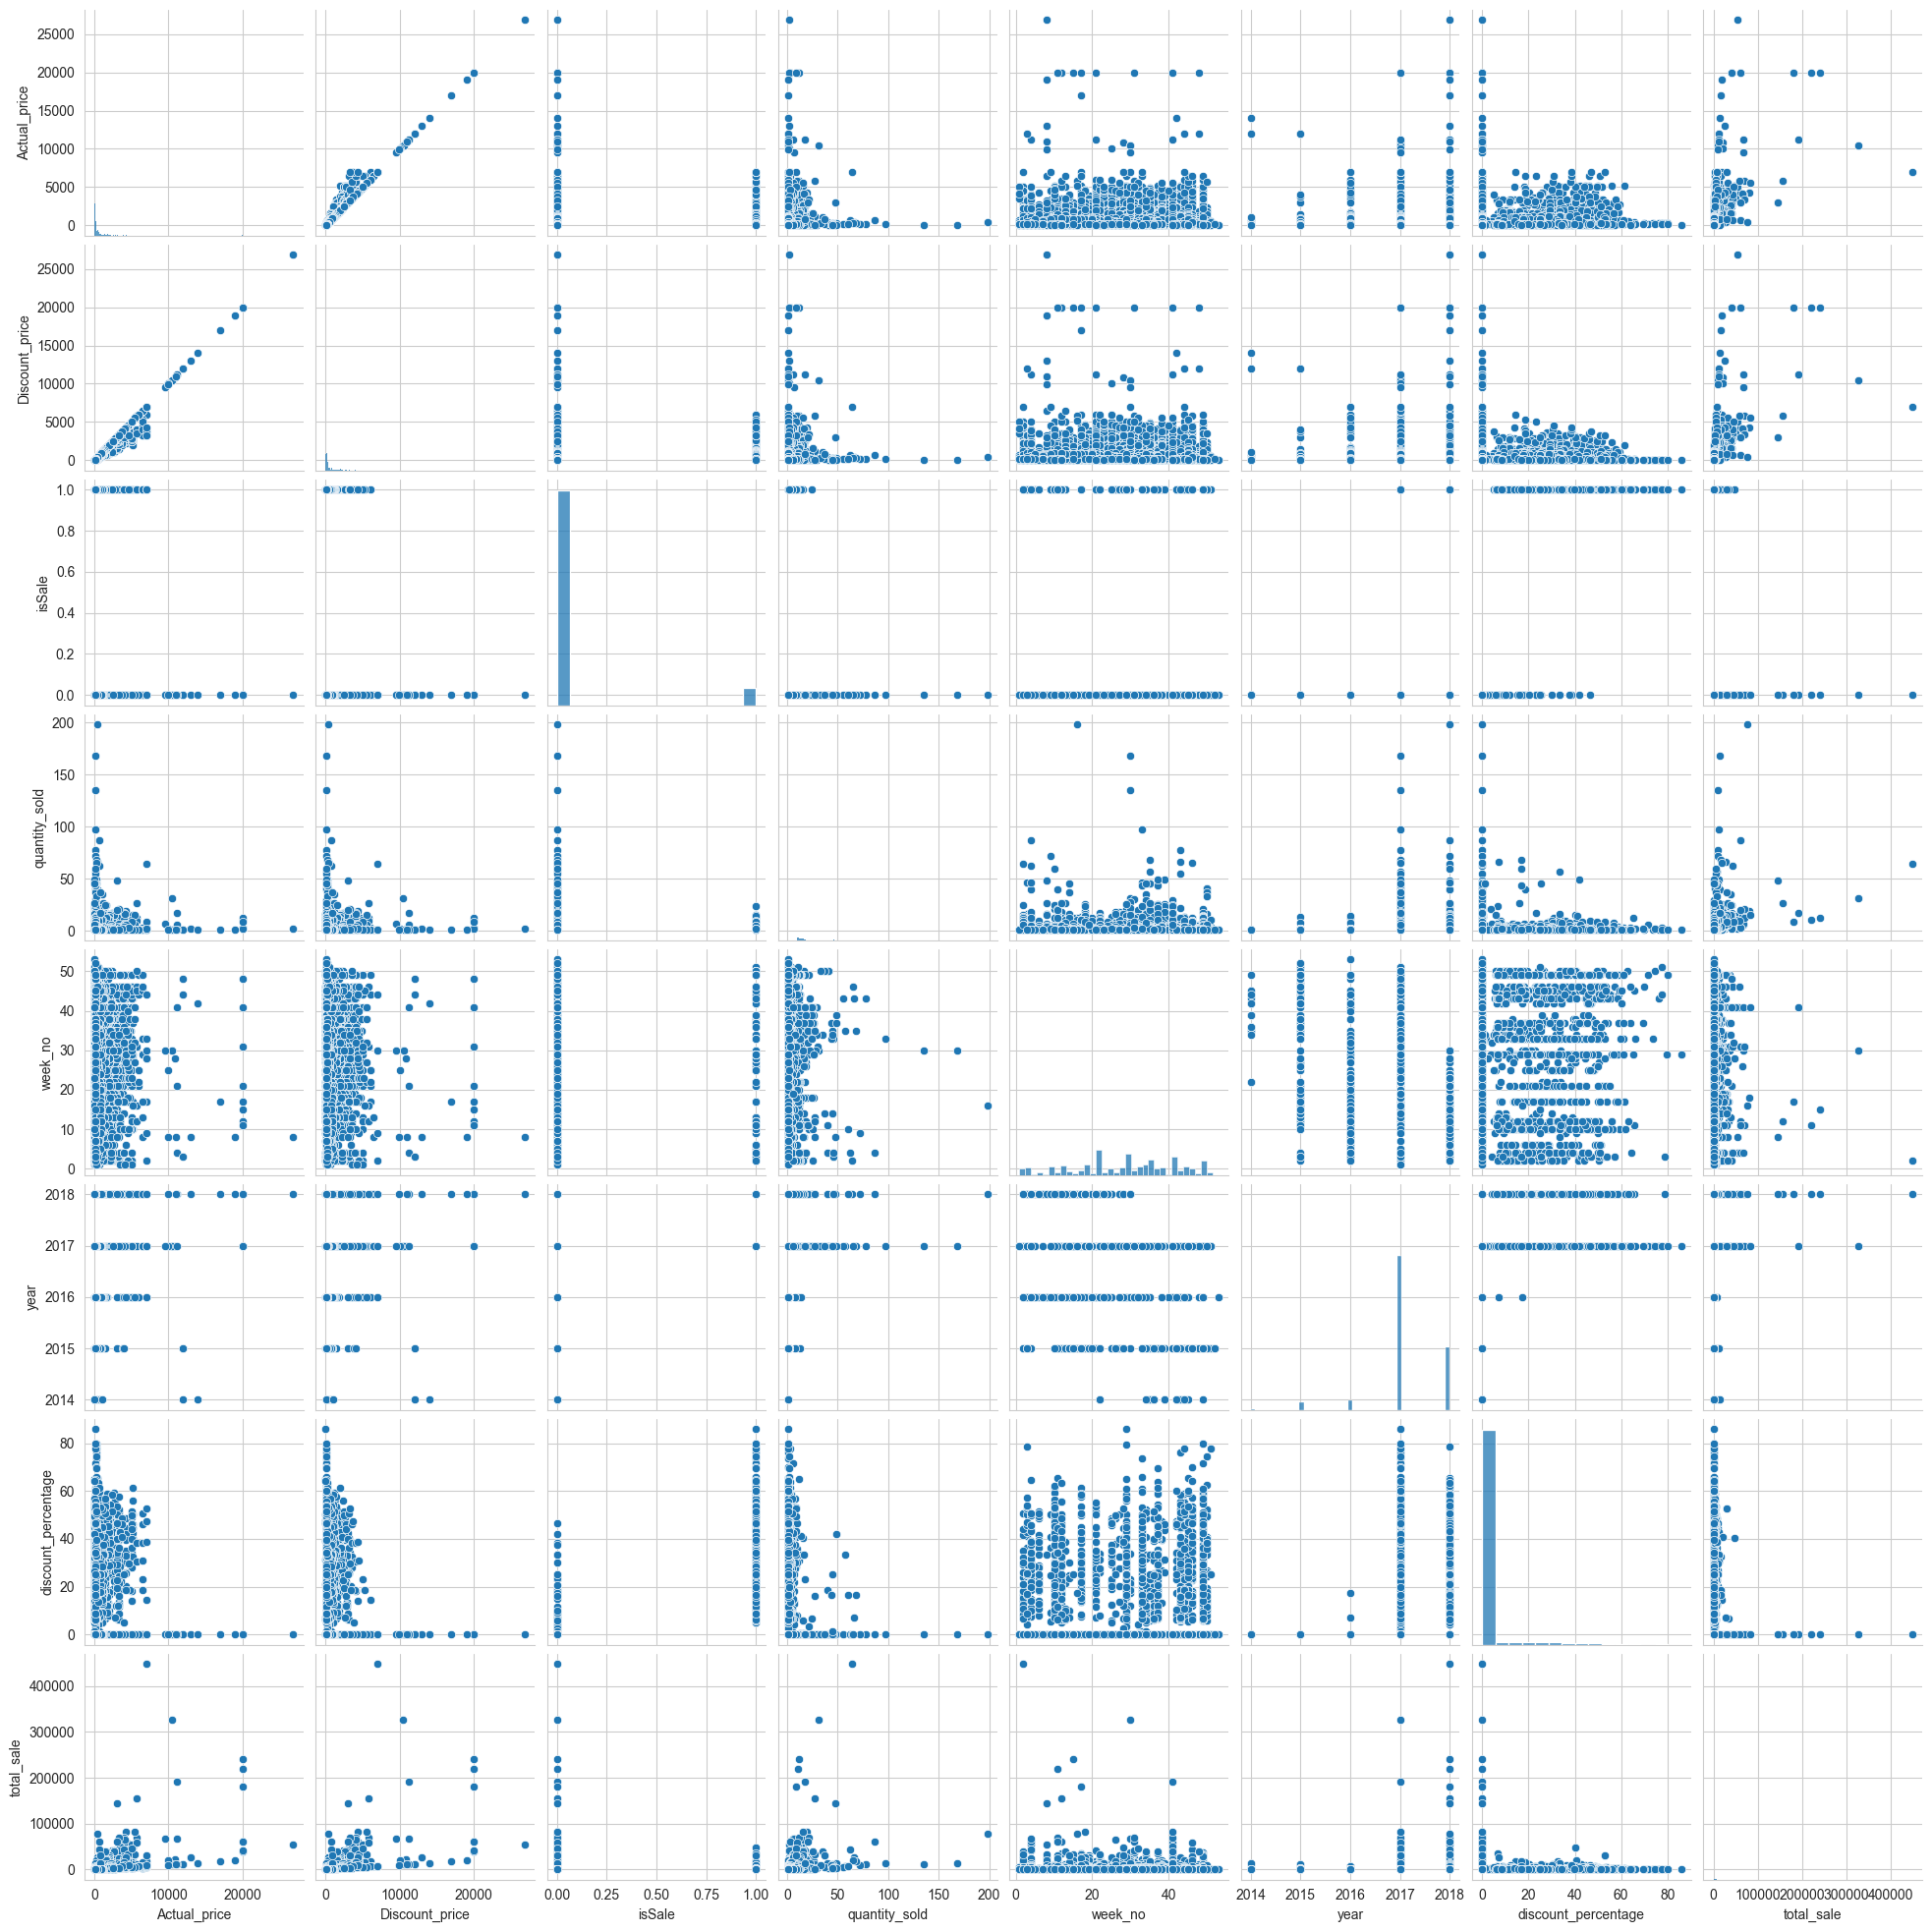

In [449]:
sns.pairplot(sub_df)

<AxesSubplot: >

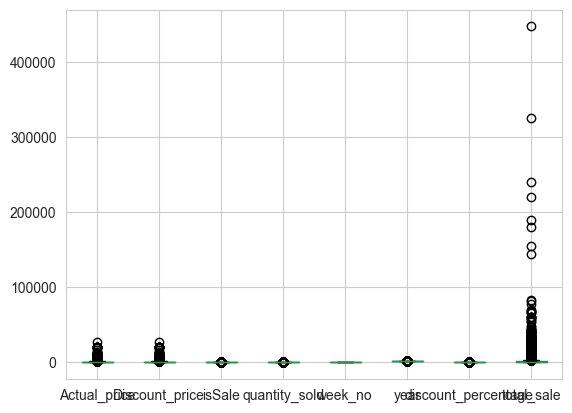

In [450]:
# detection of Outliers
sub_df.boxplot()

[]

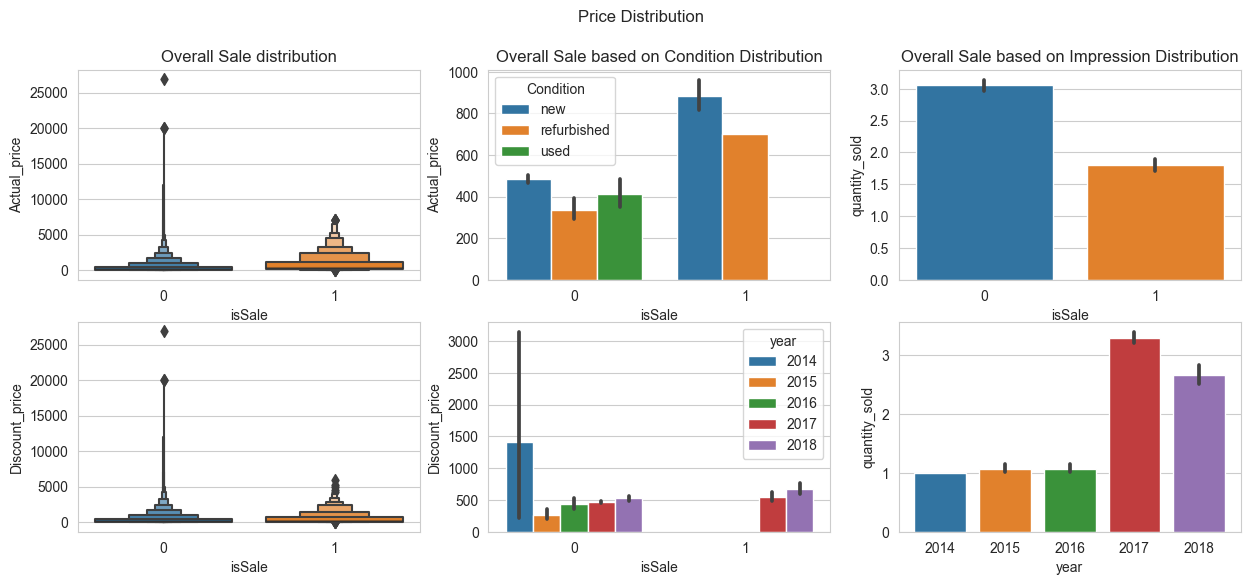

In [451]:
sns.set_style("whitegrid")

fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(15, 6))
fig.suptitle('Price Distribution')
axes[0,0].set_title('Overall Sale distribution')
axes[0,1].set_title('Overall Sale based on Condition Distribution')
axes[0,2].set_title('Overall Sale based on Impression Distribution')


sns.boxenplot(ax=axes[0,0],y=sub_df['Actual_price'],x=sub_df['isSale'])
plt.plot()


# sns.set_style("whitegrid")
ax =sns.barplot(ax=axes[0,1],y=sub_df['Actual_price'],x=sub_df['isSale'],hue=sub_df['Condition'])
plt.plot()


ax =sns.barplot(ax=axes[0,2],y=sub_df['quantity_sold'],x=sub_df['isSale'])
plt.plot()


ax=sns.boxenplot(ax=axes[1,0],y=sub_df['Discount_price'],x=sub_df['isSale'])
plt.plot()


ax =sns.barplot(ax=axes[1,1],y=sub_df['Discount_price'],x=sub_df['isSale'],hue=sub_df['year'])
plt.plot()


ax =sns.barplot(ax=axes[1,2],y=sub_df['quantity_sold'],x=sub_df['year'])
plt.plot()

<AxesSubplot: title={'center': 'Overall Price distribution'}, xlabel='Actual_price', ylabel='Count'>

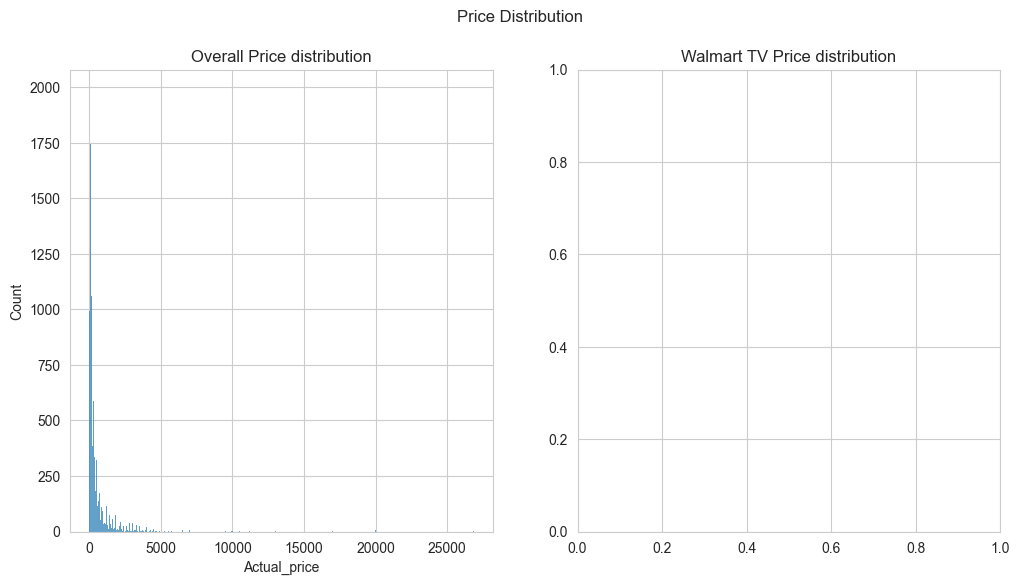

In [454]:
# fig, axes = plt.subplots(1, 2, figsize=(12, 6))
# fig.suptitle('Price Distribution')
# axes[0].set_title('Overall Price distribution')
# axes[1].set_title('Walmart TV Price distribution')

# sns.histplot(ax= axes[0],data = sub_df['Actual_price'])
# sns.histplot(ax= axes[1],data = walmart_df['Actual_price'])

In [455]:
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(nrows=2,ncols=3, figsize=(15, 6))
# fig.suptitle('Price Distribution')
# axes[0,0].set_title('Overall Sale distribution')
# axes[0,1].set_title('Overall Sale based on Condition Distribution')
# axes[0,2].set_title('Overall Sale based on Impression Distribution')


# sns.barplot(ax=axes[0,0],x=sub_df['isSale'],y=sub_df['quantity_sold'],hue=sub_df['year'])
# plt.plot()


# # sns.set_style("whitegrid")
# ax =sns.barplot(ax=axes[0,1],y=sub_df['Product_availability'],x=sub_df['Condition'],hue=sub_df['year'])
# plt.plot()


# ax =sns.barplot(ax=axes[0,2],y=sub_df['quantity_sold'],x=sub_df['Product_availability'],hue=sub_df['year'])
# plt.plot()


# ax=sns.barplot(ax=axes[1,0],y=sub_df['Condition'],x=sub_df['Product_availability'])
# plt.plot()


# ax =sns.barplot(ax=axes[1,1],y=sub_df['Discount_price'],x=sub_df['isSale'],hue=sub_df['Condition'])
# plt.plot()


# ax =sns.barplot(ax=axes[1,2],y=sub_df['quantity_sold'],x=df1['isSale'])
# plt.plot()

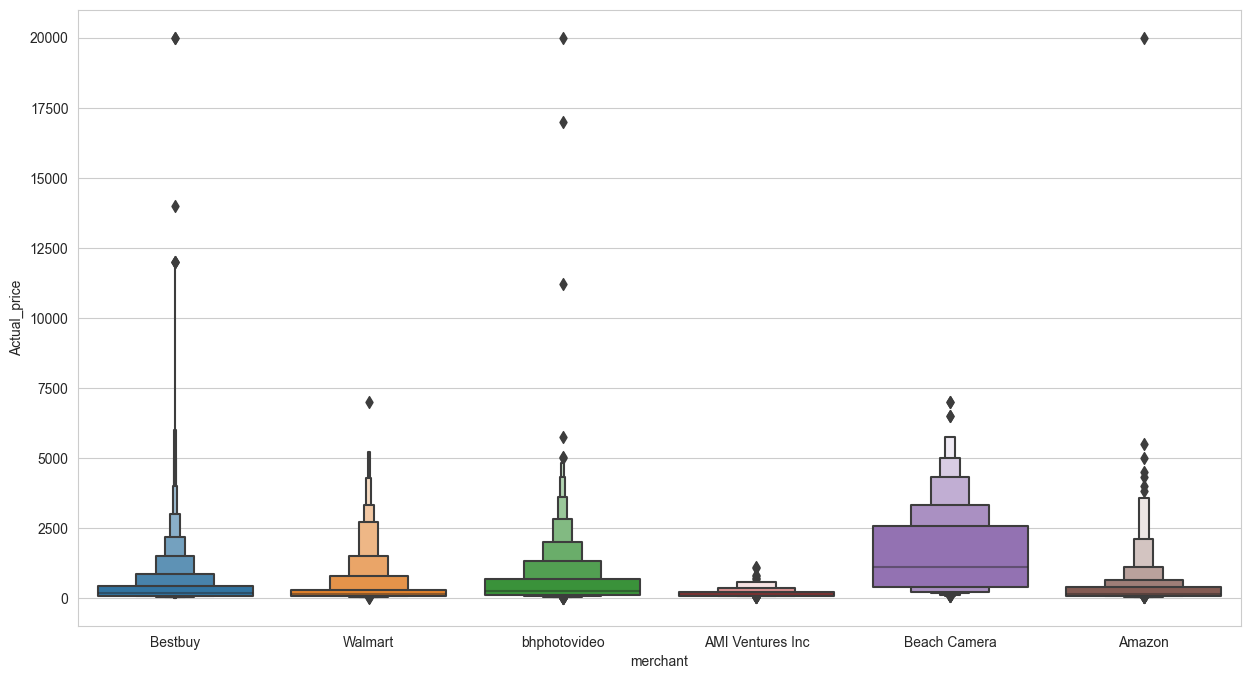

In [456]:
sel_mer=sub_df.loc[sub_df.merchant.isin(sub_df['merchant'].value_counts()[0:6].index)]
plt.figure(figsize=(15,8))
ax=sns.boxenplot(x=sel_mer['merchant'],y=sel_mer['Actual_price'])

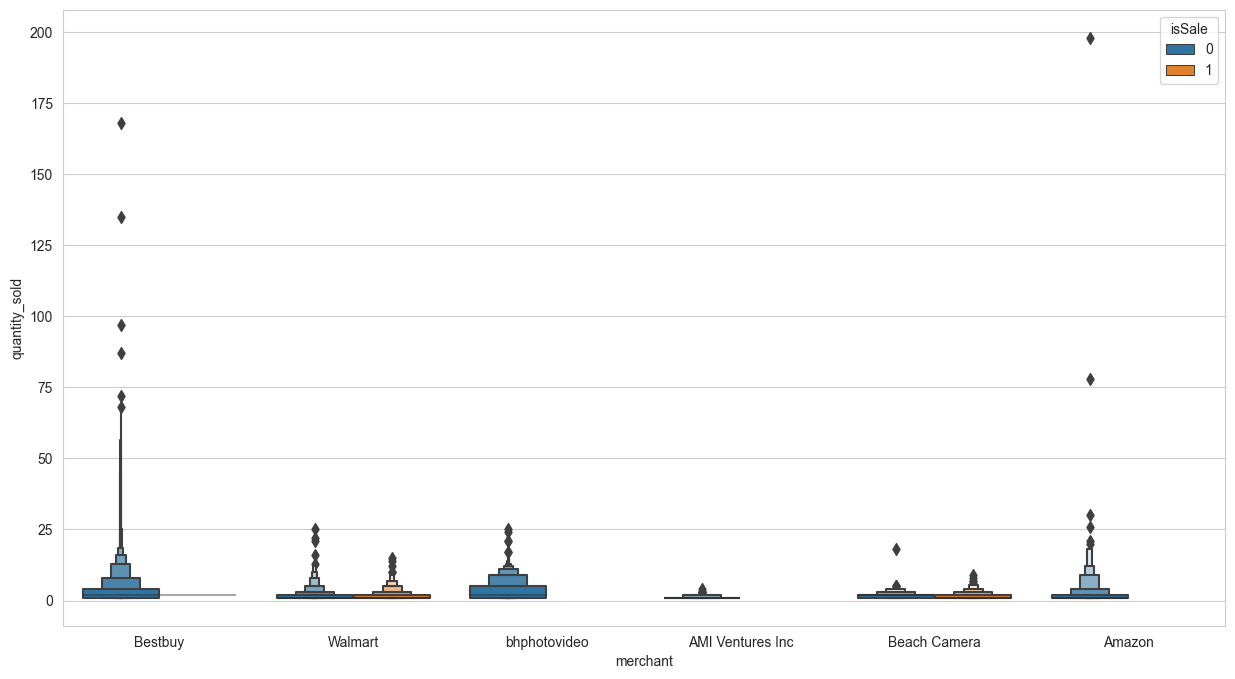

In [458]:
plt.figure(figsize=(15,8))
ax=sns.boxenplot(x=sel_mer['merchant'],y=sel_mer['quantity_sold'],hue=sel_mer['isSale'])

Product Condition analysis -
Overall "New" product category dominates with >85% of product share followed by Used and Refurbished items


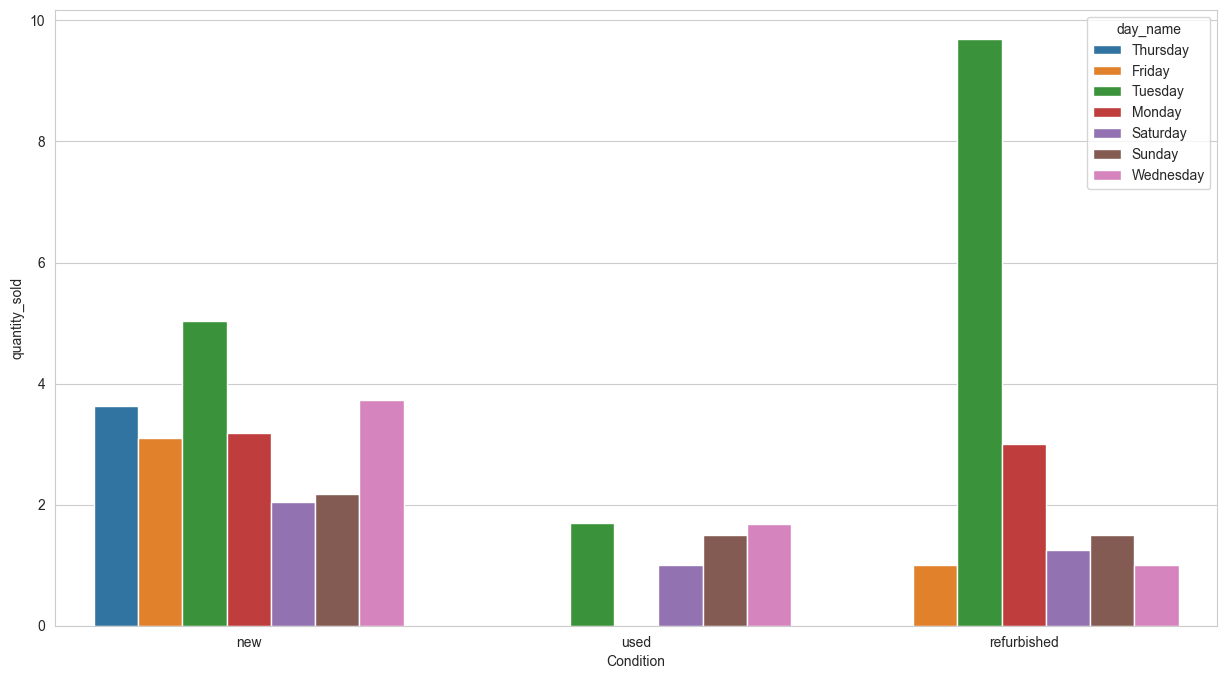

In [460]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x=sel_mer['Condition'],y=sel_mer['quantity_sold'],hue=sel_mer['day_name'],errorbar=None)

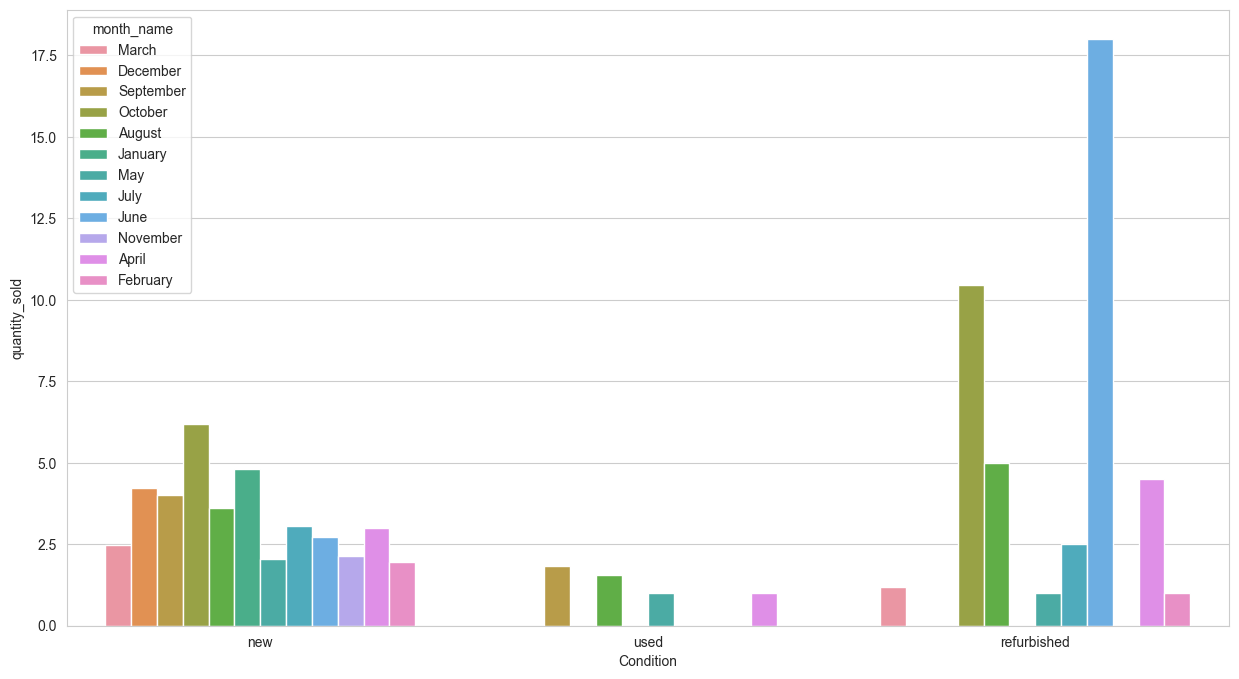

In [461]:
plt.figure(figsize=(15,8))
ax=sns.barplot(x=sel_mer['Condition'],y=sel_mer['quantity_sold'],hue=sel_mer['month_name'],errorbar=None)

## Univariate_analysis

In [463]:
def uni_analysis(s):
    print(s.describe())
    fig,axs=plt.subplots(ncols=2,figsize=(10,5))
    sns.distplot(s,ax=axs[0],color='red')
    sns.boxenplot(s,ax=axs[1],color='green')
    
    

count    14592.000000
mean       509.578897
std       1008.512738
min          1.000000
25%         79.990000
50%        195.000000
75%        499.990000
max      26871.000000
Name: Actual_price, dtype: float64


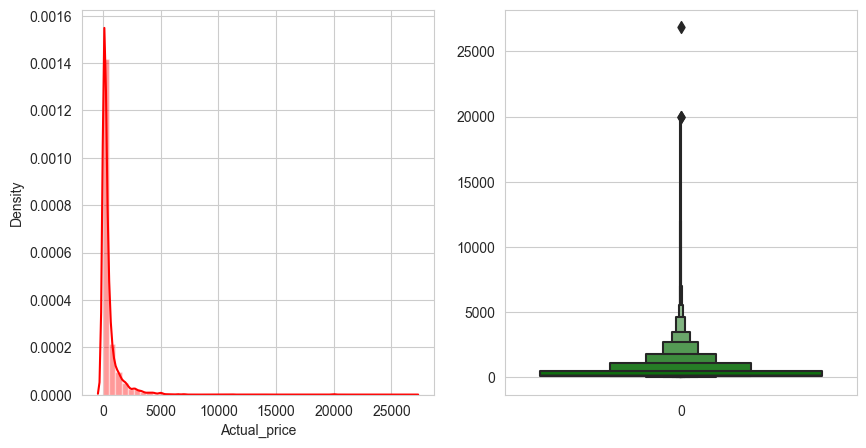

In [462]:
d1=sub_df['Actual_price']
uni_analysis(d1)

count    14592.000000
mean       487.323215
std        967.083200
min          1.000000
25%         79.950000
50%        188.035000
75%        499.000000
max      26871.000000
Name: Discount_price, dtype: float64


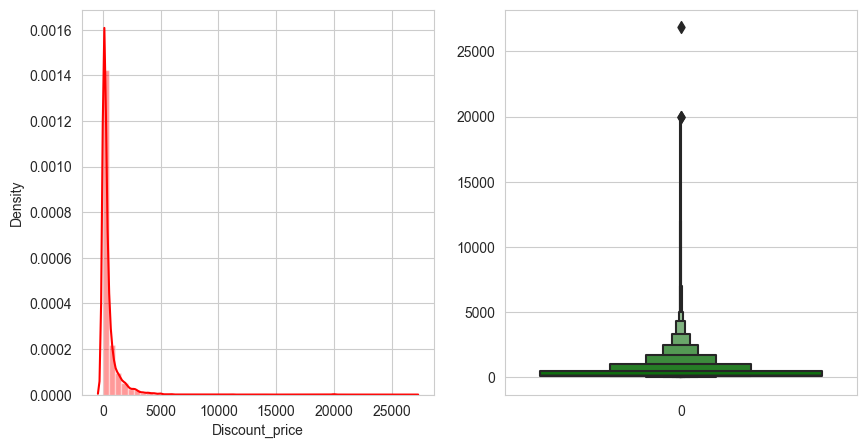

In [464]:
d2=sub_df['Discount_price']
uni_analysis(d2)

count    14592.000000
mean         2.963130
std          4.849232
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        198.000000
Name: quantity_sold, dtype: float64


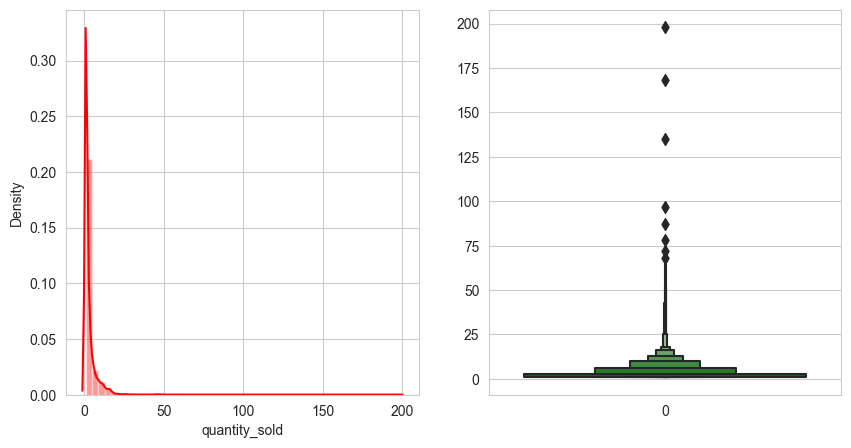

In [466]:
d3=sub_df['quantity_sold']
uni_analysis(d3)

<AxesSubplot: xlabel='year', ylabel='quantity_sold'>

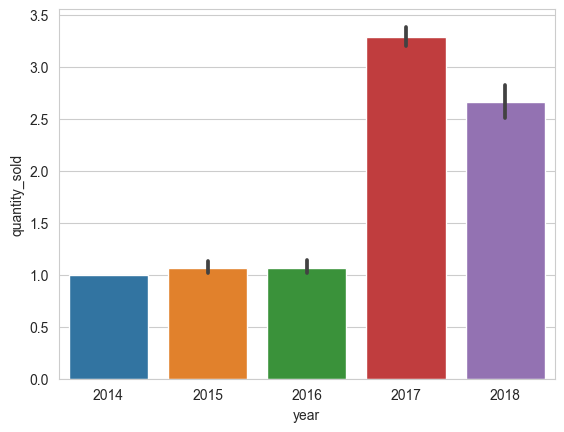

In [468]:
sns.barplot(y=sub_df['quantity_sold'],x=sub_df['year'],)

Product_availability
no        0.589364
other     3.693805
yes      95.716831
Name: Product_availability, dtype: float64


Currency
CAD     0.363213
EUR     0.226151
GBP     0.013706
SGD     0.054825
USD    99.342105
Name: Currency, dtype: float64

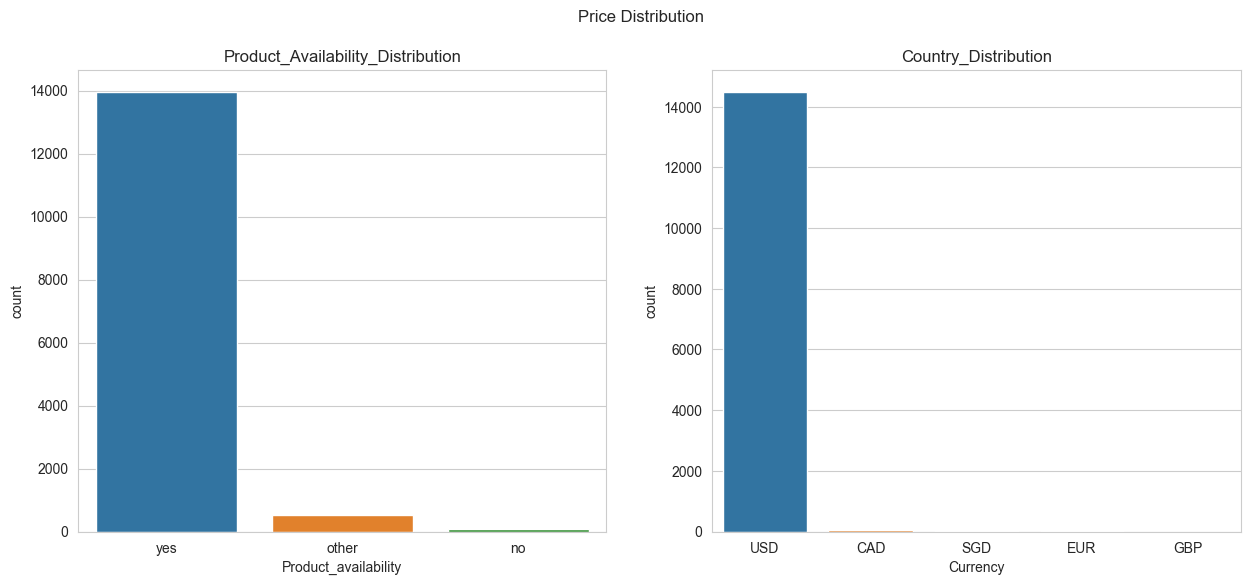

In [473]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Price Distribution')

axes[0].set_title('Product_Availability_Distribution')
axes[1].set_title('Country_Distribution')


sns.countplot(ax=axes[0],x="Product_availability", data=sub_df)
sns.countplot(ax=axes[1],x="Currency", data=sub_df)

print((sub_df.groupby('Product_availability')['Product_availability'].count()/sub_df.shape[0])*100)
(sub_df.groupby('Currency')['Currency'].count()/sub_df.shape[0])*100

<AxesSubplot: >

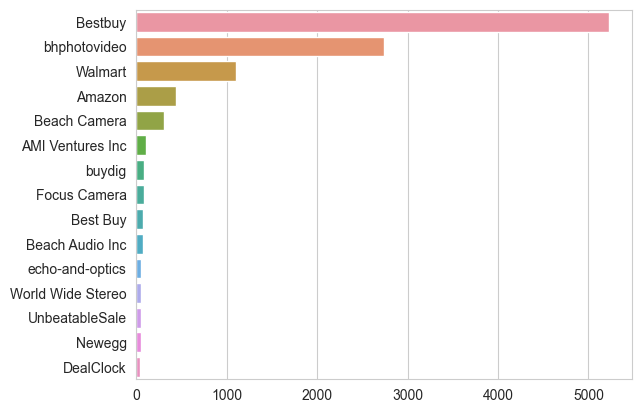

In [486]:
sns.barplot( x = sub_df['merchant'].value_counts().values[:15],y = sub_df['merchant'].value_counts().index[:15])

In [474]:
sub_df.corr().tail(1)

,Actual_price,Discount_price,isSale,quantity_sold,week_no,year,discount_percentage,total_sale
total_sale,0.511804,0.526486,-0.01483,0.331459,-0.011863,0.038701,-0.008271,1.0


when we see the correation we  continuous vs continuous var

<AxesSubplot: >

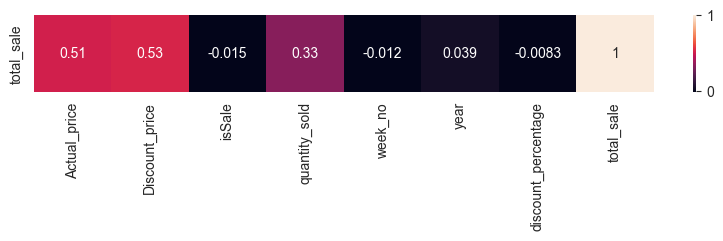

In [475]:
plt.figure(figsize=(10,1))
sns.heatmap(sub_df.corr().tail(1),annot=True)

In [69]:
# df1.to_excel('clean.xlsx',sheet_name='data')

In [488]:
# sub_df.isna().sum()

## Feature_selection

For selection of feature we will first use some Filter methods to check 
relationship bet ind vars.

In [489]:
from sklearn.feature_selection import chi2,_univariate_selection,mutual_info_regression
from sklearn.feature_selection import VarianceThreshold
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [491]:
#filtered only Walmart store and Tv category just to keep it simple
walmart_df = sub_df[sub_df['merchant'] == 'Walmart']
walmart_df = walmart_df[walmart_df.Category_name == 'tv, television, led']
walmart_df 

,id,Actual_price,Discount_price,Product_availability,Condition,Currency,Date,isSale,merchant,brand,...,Category_name,primaryCategories,name,quantity_sold,week_no,month_name,day_name,year,discount_percentage,total_sale
169,AV13iAUYGV-KLJ3aka9M,599.99,397.99,yes,new,USD,2018-05-28 07:00:00+00:00,1,Walmart,Samsung,...,"tv, television, led",Electronics,"Samsung - 50 Class (49.5"" Diag.) - LED - 1080p...",4,22,May,Monday,2018,33.667228,1591.96
172,AV13iAUYGV-KLJ3aka9M,599.99,477.99,yes,new,USD,2017-09-07 14:00:00+00:00,1,Walmart,Samsung,...,"tv, television, led",Electronics,"Samsung - 50 Class (49.5"" Diag.) - LED - 1080p...",2,36,September,Thursday,2017,20.333672,955.98
175,AV13iAUYGV-KLJ3aka9M,599.99,497.99,yes,new,USD,2017-10-24 01:00:00+00:00,1,Walmart,Samsung,...,"tv, television, led",Electronics,"Samsung - 50 Class (49.5"" Diag.) - LED - 1080p...",2,43,October,Tuesday,2017,17.000283,995.98
179,AV13iAUYGV-KLJ3aka9M,599.99,447.99,yes,new,USD,2017-11-16 19:00:00+00:00,1,Walmart,Samsung,...,"tv, television, led",Electronics,"Samsung - 50 Class (49.5"" Diag.) - LED - 1080p...",1,46,November,Thursday,2017,25.333756,447.99
182,AV13iAUYGV-KLJ3aka9M,599.99,329.99,yes,new,USD,2018-04-26 17:00:00+00:00,1,Walmart,Samsung,...,"tv, television, led",Electronics,"Samsung - 50 Class (49.5"" Diag.) - LED - 1080p...",1,17,April,Thursday,2018,45.000750,329.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11769,AV1YHqpxglJLPUi8IGyt,1097.99,747.99,yes,new,USD,2018-01-28 10:00:00+00:00,1,Walmart,Samsung,...,"tv, television, led",Electronics,Details About Samsung 55 Class 4k (2160p) Smar...,1,4,January,Sunday,2018,31.876429,747.99
11800,AV1YHqpxglJLPUi8IGyt,635.00,635.00,yes,new,USD,2018-01-10 07:00:00+00:00,0,Walmart,Samsung,...,"tv, television, led",Electronics,Details About Samsung 55 Class 4k (2160p) Smar...,1,2,January,Wednesday,2018,0.000000,635.00
11804,AWFFsPtgHh53nbDRF1s5,127.91,127.91,yes,new,USD,2018-01-10 10:00:00+00:00,0,Walmart,WD,...,"tv, television, led",Electronics,4TB My Book Desktop USB 3.0 External Hard Drive,1,2,January,Wednesday,2018,0.000000,127.91
12853,AVzYu3JmGV-KLJ3abUGc,127.99,127.99,yes,new,USD,2017-10-30 15:00:00+00:00,0,Walmart,Samsung,...,"tv, television, led",Electronics,Samsung Galaxy Tab E Lite Kids 7; 8 GB Wifi Ta...,3,44,October,Monday,2017,0.000000,383.97


In [502]:
# Converting week level data Price change for all the different products
Week_price_df = walmart_df.groupby(['name', 'week_no']).agg({'Discount_price':'mean','quantity_sold':'sum'}).reset_index()
x_pivot = Week_price_df.pivot(index='week_no', columns='name' ,values='Discount_price')
# x_pivot.to_records() #Convert DataFrame to a NumPy record array.

name,4TB My Book Desktop USB 3.0 External Hard Drive,D-Link - DCS Indoor 720p Wi-Fi Network Surveillance Cameras (2-Pack) - White,"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""","Details About Samsung 55 Class 4k (2160p) Smart Led Tv (un55mu7000fxza)""",Details About Samsung Electronics Un49mu8000 49inch 4k (2160p) Uhd Led Lcd Internet Smart Tv,Hisense 50H4D Roku 50-inch HD Smart DLED TV,J5202-Series 43-Class Full HD Smart LED TV,J5205 32-Class Full HD Smart LED TV,"LG - 28 Class (27.5"" Diag.) - LED - 720p - HDTV""",MU8000-Series 65-Class HDR UHD Smart LED TV,...,"Samsung - 49 Class - LED - Q6F Series - 2160p - Smart - 4K UHD TV with HDR""","Samsung - 50 Class (49.5"" Diag.) - LED - 1080p - Smart - HDTV""","Samsung - 55 Class - LED - Curved - MU6490 Series - 2160p - Smart - 4K Ultra HD TV with HDR""","Samsung - 55 Class - LED - Curved - Q7C Series - 2160p - Smart - 4K UHD TV with HDR""","Samsung - 55 Class - LED - Q8F Series - 2160p - Smart - 4K UHD TV with HDR""","Samsung - 65 Class - LED - MU6290 Series - 2160p - Smart - 4K Ultra HD TV with HDR""","Samsung Galaxy Tab E Lite Kids 7; 8 GB Wifi Tablet (White) SM-T113NDWACCC""",Samsung J1 (Verizon LTE Prepaid),W650D-Series 48-Class Full HD Smart LED TV,XBR-X850E-Series 75-Class HDR UHD Smart LED TV
week_no,,,,,,,,,,,,,,,,,,,,,
2,127.91,NaN,NaN,635.00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,119.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998.0
4,NaN,NaN,NaN,747.99,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,847.99,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,997.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,138.00,NaN,779.92,NaN,NaN,NaN,NaN,1097.71,...,897.99,NaN,NaN,1497.99,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,798.00,NaN,NaN,NaN,NaN
17,NaN,NaN,109.99,549.99,NaN,NaN,319.99,NaN,NaN,NaN,...,797.99,329.99,1197.99,NaN,2097.99,NaN,NaN,NaN,NaN,NaN
21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,1097.99,1399.99,1997.99,797.99,NaN,NaN,NaN,NaN
22,NaN,NaN,86.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,397.99,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [503]:
# Week_price_df

In [494]:
# Impute using forward fill, here we are assuming that if any week is missing price 
# then its price does not get change in coming weeks
x_values = pd.DataFrame(x_pivot.to_records())
x_values.fillna(method='ffill', inplace=True)

In [495]:
# Converting week level data quantity sold for all the different products
y_pivot = Week_price_df.pivot(index='week_no', columns='name', values='quantity_sold')
y_values = pd.DataFrame(y_pivot.to_records())
y_values.fillna(method='ffill', inplace=True)

In [496]:
x_pivot.head(2)

name,4TB My Book Desktop USB 3.0 External Hard Drive,D-Link - DCS Indoor 720p Wi-Fi Network Surveillance Cameras (2-Pack) - White,"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""","Details About Samsung 55 Class 4k (2160p) Smart Led Tv (un55mu7000fxza)""",Details About Samsung Electronics Un49mu8000 49inch 4k (2160p) Uhd Led Lcd Internet Smart Tv,Hisense 50H4D Roku 50-inch HD Smart DLED TV,J5202-Series 43-Class Full HD Smart LED TV,J5205 32-Class Full HD Smart LED TV,"LG - 28 Class (27.5"" Diag.) - LED - 720p - HDTV""",MU8000-Series 65-Class HDR UHD Smart LED TV,...,"Samsung - 49 Class - LED - Q6F Series - 2160p - Smart - 4K UHD TV with HDR""","Samsung - 50 Class (49.5"" Diag.) - LED - 1080p - Smart - HDTV""","Samsung - 55 Class - LED - Curved - MU6490 Series - 2160p - Smart - 4K Ultra HD TV with HDR""","Samsung - 55 Class - LED - Curved - Q7C Series - 2160p - Smart - 4K UHD TV with HDR""","Samsung - 55 Class - LED - Q8F Series - 2160p - Smart - 4K UHD TV with HDR""","Samsung - 65 Class - LED - MU6290 Series - 2160p - Smart - 4K Ultra HD TV with HDR""","Samsung Galaxy Tab E Lite Kids 7; 8 GB Wifi Tablet (White) SM-T113NDWACCC""",Samsung J1 (Verizon LTE Prepaid),W650D-Series 48-Class Full HD Smart LED TV,XBR-X850E-Series 75-Class HDR UHD Smart LED TV
week_no,,,,,,,,,,,,,,,,,,,,,
2,127.91,NaN,NaN,635.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,119.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1998.0


We have a lot of product in the list and for each one we need to create a separate model
with respect to their price and quantity sold

Price elasticity = Change in Quanity sold / Change in the Price

In [497]:
final_df = pd.DataFrame()
for col in x_values.columns[1:]:

    results_values = {
    "name": [],
    "price_elasticity": [],
    "price_mean": [],
    "quantity_mean": [],
    "intercept": [],
    "t_score":[],
    "slope": [],
    "coefficient_pvalue" : [],
    "rsquared": [],
    }

    temp_df1 = pd.DataFrame()
    temp_df1['x'] = x_values[col]
    temp_df1['y'] = y_values[col]
    temp_df1.dropna(inplace=True)
    x_value = temp_df1['x']
    y_value = temp_df1['y']
    X = sm.add_constant(x_value)
    model = sm.OLS(y_value, X)
    result = model.fit()

    #choose only those whose P-value is less than 5% errornous
    if result.f_pvalue < 0.05:

        rsquared = result.rsquared
        coefficient_pvalue = result.f_pvalue
        try:
            intercept,slope = result.params
        except:
            slope = result.params
        mean_price = np.mean(x_value)
        mean_quantity = np.mean(y_value)
        try:
            tintercept, t_score = result.tvalues
        except:
            pass
        
        #Price elasticity Formula
        price_elasticity = (slope)*(mean_price/mean_quantity)

            
            
        #Append results into dictionary for dataframe
        results_values["name"].append(col)
        results_values["price_elasticity"].append(price_elasticity)
        results_values["price_mean"].append(mean_price)
        results_values["quantity_mean"].append(mean_quantity)
        results_values["intercept"].append(intercept)
        results_values['t_score'].append(t_score)
        results_values["slope"].append(slope)
        results_values["coefficient_pvalue"].append(coefficient_pvalue)
        results_values["rsquared"].append(rsquared)

        final_df = pd.concat([final_df,pd.DataFrame.from_dict(results_values)],axis=0,ignore_index=True)

In [498]:
final_df

,name,price_elasticity,price_mean,quantity_mean,intercept,t_score,slope,coefficient_pvalue,rsquared
0,MU8000-Series 65-Class HDR UHD Smart LED TV,2.157049,1237.822000,1.200000,-1.388458,2.187127e+00,0.002091,4.760915e-02,0.268986
1,Power Acoustik EG1-4500D Edge Series Monoblock...,-14.511225,150.324444,1.888889,29.298981,-1.730458e+01,-0.182340,5.289560e-07,0.977158
2,Refurbished Vizio 55 Class 4K (2160P) Smart LE...,12.668072,692.665556,4.555556,-53.154551,1.560271e+14,0.083316,1.173208e-97,1.000000
3,SAMSUNG 65 Class 4K (2160P) Ultra HD Smart QLE...,1.170133,1348.458000,3.266667,-0.555769,4.051637e+00,0.002835,1.372148e-03,0.558060
4,"Samsung - 32 Class (31.5"" Diag.) - LED - 720p ...",-414.981944,229.836154,1.384615,575.975000,-inf,-2.500000,0.000000e+00,1.000000
5,Samsung - 49 Class - LED - Q6F Series - 2160p ...,-3.762240,822.990000,3.500000,16.667840,-5.870395e+00,-0.016000,4.071941e-05,0.711111
6,Samsung - 55 Class - LED - Curved - MU6490 Ser...,2.324745,990.297692,2.076923,-2.751394,3.809401e+00,0.004876,2.895763e-03,0.568823
7,Samsung - 55 Class - LED - Q8F Series - 2160p ...,-14.093984,2005.682308,2.846154,42.959800,-1.474532e+14,-0.020000,1.753276e-151,1.000000
8,Samsung - 65 Class - LED - MU6290 Series - 216...,-8.604106,812.697059,2.411765,23.162844,-6.597609e+00,-0.025534,8.471280e-06,0.743714
9,Samsung Galaxy Tab E Lite Kids 7; 8 GB Wifi Ta...,3.581911,115.132857,2.142857,-5.532667,3.806236e+15,0.066667,2.375883e-77,1.000000


In [500]:
# Getting unique Name and Brand Name mapping list

Name_Brand_Mapping = sub_df[~sub_df[['name','brand']].duplicated()][['name','brand']]


#Map brand name with the product name to see what brand see, how much % change

final_df = final_df.merge(Name_Brand_Mapping,how='left',on='name')

final_df = final_df.sort_values(by=['price_elasticity'])

temp_df = final_df.iloc[2:][['name','price_elasticity']]

final_df[['name','price_elasticity']].iloc[2:]

,name,price_elasticity
2,Samsung - 55 Class - LED - Q8F Series - 2160p ...,-14.093984
3,Samsung - 65 Class - LED - MU6290 Series - 216...,-8.604106
4,Samsung - 49 Class - LED - Q6F Series - 2160p ...,-3.762240
5,SAMSUNG 65 Class 4K (2160P) Ultra HD Smart QLE...,1.170133
6,MU8000-Series 65-Class HDR UHD Smart LED TV,2.157049
7,Samsung - 55 Class - LED - Curved - MU6490 Ser...,2.324745
8,Samsung Galaxy Tab E Lite Kids 7; 8 GB Wifi Ta...,3.581911
9,XBR-X850E-Series 75-Class HDR UHD Smart LED TV,6.720727
10,Refurbished Vizio 55 Class 4K (2160P) Smart LE...,12.668072


[Text(0, 0, '-14.094'),
 Text(0, 0, '-8.60411'),
 Text(0, 0, '-3.76224'),
 Text(0, 0, '1.17013'),
 Text(0, 0, '2.15705'),
 Text(0, 0, '2.32475'),
 Text(0, 0, '3.58191'),
 Text(0, 0, '6.72073'),
 Text(0, 0, '12.6681')]

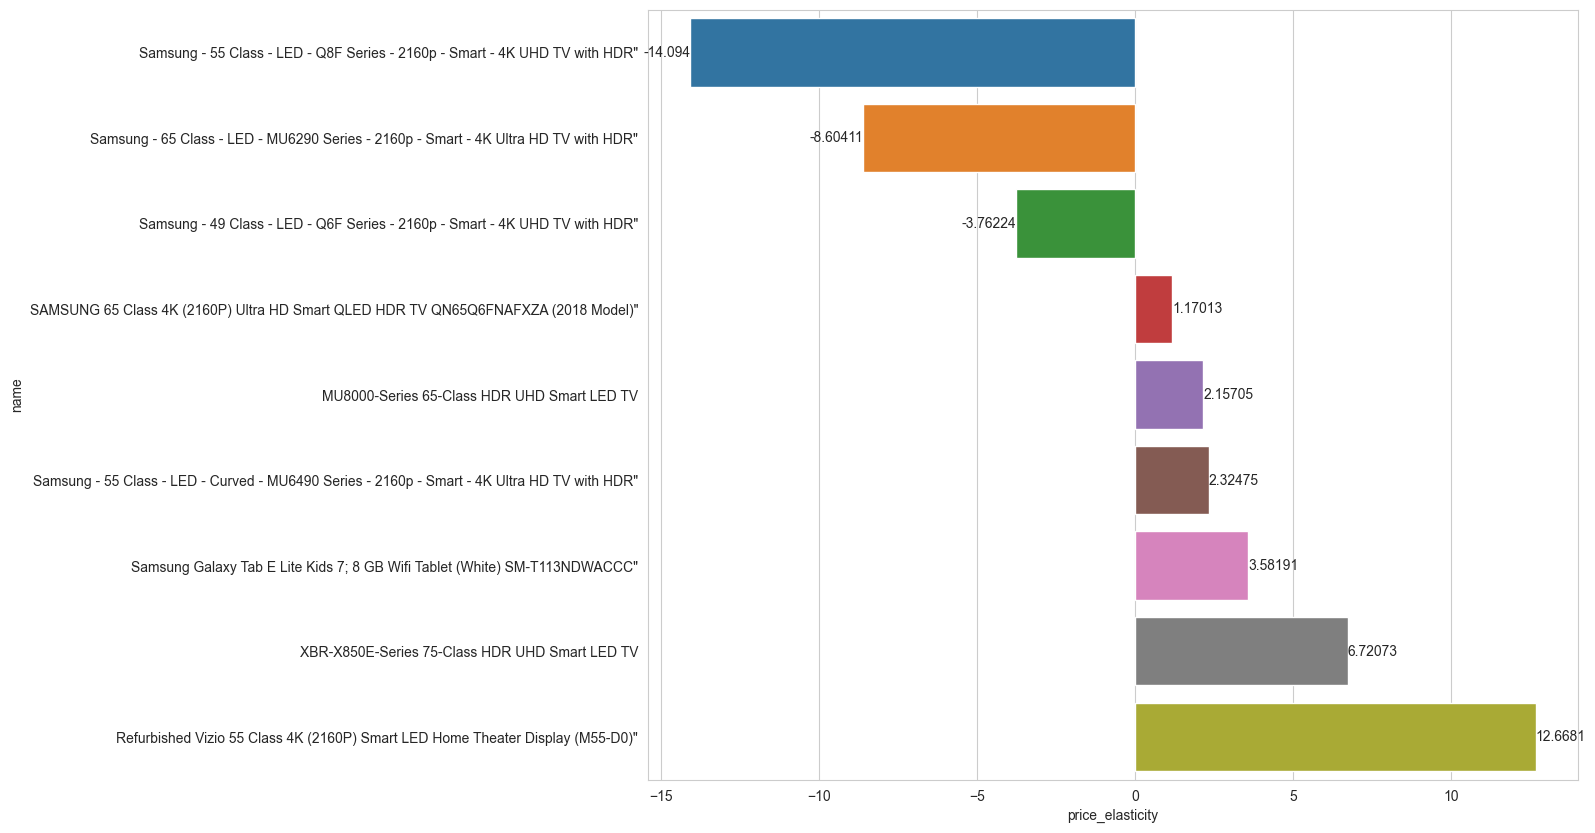

In [501]:
# temp_df
plt.figure(figsize=(12,10))
ax= sns.barplot(x=temp_df['price_elasticity'],y=temp_df['name'])
ax.bar_label(ax.containers[0])

In the above we notice that Samsung-65 Class LED TV with a negative price elasticity of -17.68,
it is described as follows: “A 10% price decrease in Samsung-65 Class LED, it increases sales demand
by 170.6% or a 10% price increase, it decreases sales demand by 170.6%”

Whereas in other case, Sony XBR-X850E-Series 75-Class TV with a negative price elasticity of 7.19 & 
interpreted as - “A 10% price decrease in XBR-X850E-Series 75-Class TV, it decreases sales demand by
71.2% or a 10% price increase, it increases sales demand by 71.2%”

<AxesSubplot: >

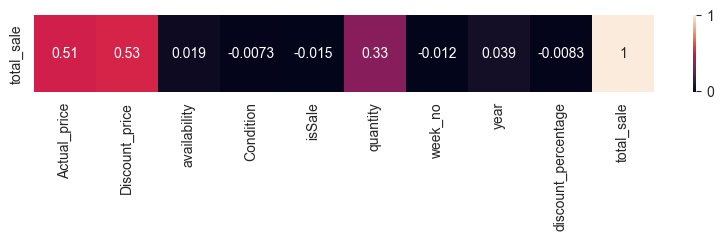

In [336]:
# using deafault 'pearson'
df1.corr().tail(1)
plt.figure(figsize=(10,1))
sns.heatmap(df1.corr().tail(1),annot=True)

<AxesSubplot: >

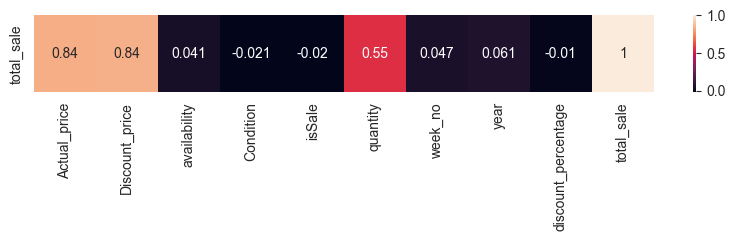

In [337]:
# using deafault ''spearman''
plt.figure(figsize=(10,1))
sns.heatmap(df1.corr(method='spearman').tail(1),annot=True)


<AxesSubplot: >

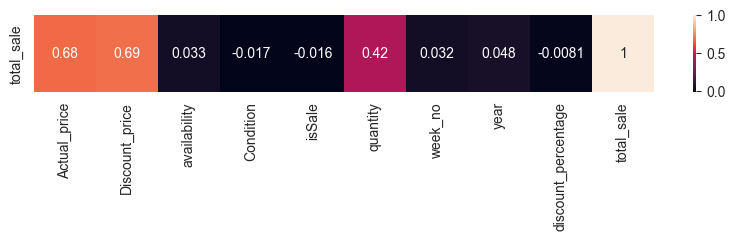

In [338]:
# using deafault 'kendall'

plt.figure(figsize=(10,1))
sns.heatmap(df1.corr(method='kendall').tail(1),annot=True)

<AxesSubplot: >

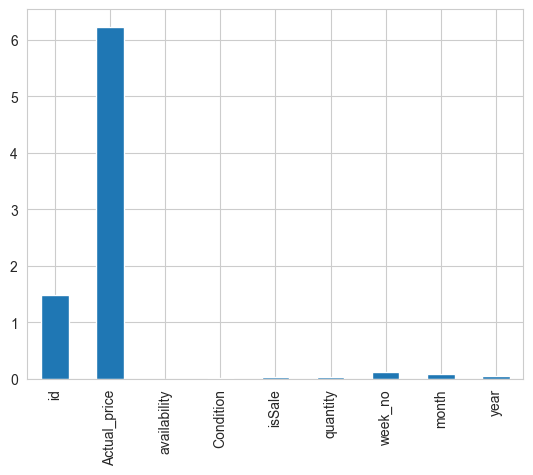

In [149]:
# Estimate mutual information for a continuous target variable.

# Mutual information (MI) [1]_ between two random variables is a non-negative
# value, which measures the dependency between the variables. It is equal
# to zero if and only if two random variables are independent, and higher
# values mean higher dependency.

x=df1.drop(columns=['Discount_price','dateseen','merchant','brand','name'],axis=1)
y=df1['Discount_price']
arr1=mutual_info_regression(x,y)
s1=pd.Series(arr1,index=x.columns)

s1.plot(kind='bar')

## Fisher_score

In [151]:
!pip install skfeature

ERROR: Could not find a version that satisfies the requirement skfeature (from versions: none)
ERROR: No matching distribution found for skfeature


## VarianceThreshold

In [157]:
vt=VarianceThreshold(threshold=0.2)
vt

VarianceThreshold(threshold=0.2)

In [159]:
vt.fit(x)


VarianceThreshold(threshold=0.2)

In [164]:
arr2=vt.get_support()


In [167]:
for i in range(len(x.columns)):
    print(x.columns[i],    '::',  arr2[i])

id :: True
Actual_price :: True
availability :: False
Condition :: False
isSale :: False
quantity :: True
week_no :: True
month :: True
year :: True


### VIF- variance_inflation_factor()

<AxesSubplot: >

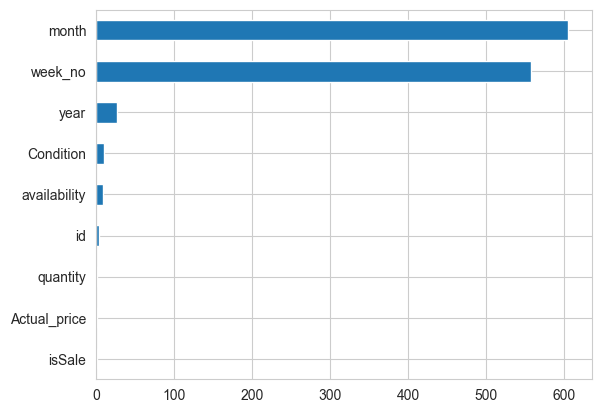

In [170]:
vif_list = []
for i in range(x.shape[1]):
    vif = variance_inflation_factor(x.values, i)
    vif_list.append(vif)
    
s4 = pd.Series(vif_list, index=x.columns)
s4.sort_values().plot(kind = 'barh')

In [72]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=3,test_size=0.30)
print(x_test.shape)
print(x_train.shape)


(463, 6)
(1080, 6)


## Model_Training

In [73]:
Lin_model=LinearRegression()
Lin_model

LinearRegression()

In [74]:
Lin_model.fit(x_train,y_train)

LinearRegression()

In [75]:
arr1=Lin_model.coef_  ## correlation 

In [76]:
arr2=Lin_model.intercept_  ## c= -11.18

## Evaluation_Of_Model

In [77]:
def Model_Evaluation(string,model,ind,act):
    print(string.center(70,'*'))
    pred=model.predict(ind)
    
    mae=mean_absolute_error(act,pred)
    print('mean_absolute_error >> ',mae)
    mse=mean_squared_error(act,pred)
    print('mean_squared_error >> ',mse)
    rmse=np.sqrt(mse)
    print('Root_mean_squared_error >> ',rmse)
    r2_val=r2_score(act,pred)
    print('R2_score >> ',r2_val)
    
print()    
Model_Evaluation(' Train data evaluation ',Lin_model,x_train,y_train)
print('* #'*25)
print()
Model_Evaluation(' Test data evaluation ',Lin_model,x_test,y_test)
print('* #'*25)
print()


*********************** Train data evaluation ************************
mean_absolute_error >>  94.32770407334793
mean_squared_error >>  55087.758148183806
Root_mean_squared_error >>  234.70781441652898
R2_score >>  0.9376525245892382
* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #

************************ Test data evaluation ************************
mean_absolute_error >>  100.3900964238885
mean_squared_error >>  50551.799460500726
Root_mean_squared_error >>  224.8372732900413
R2_score >>  0.9156881025032528
* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #* #



In [78]:
test_array=np.array([1003,189.95,1,1,0,1],ndmin=2)
test_array

Lin_model.predict(test_array)


array([173.73136037])

In [ ]:
n=1
# for i in df['id']:
#     for j in id_list:
#         if i==j:
#             df['id'].replace({i:n},inplace=True)
#         else:
#             pass
        
#     n+=1  
    
# df['id'].nunique()    